# **Thông tin môn học**
Môn học: Học sâu cho Khoa học dữ liệu

Nhóm: 7 - deepstudy

# EDA Approach 02: Semantical Analysis

Nguồn Kaggle Notebook ở [đây](https://www.kaggle.com/code/phamletunhi/eedi-semantic-analysis?scriptVersionId=218460208) 
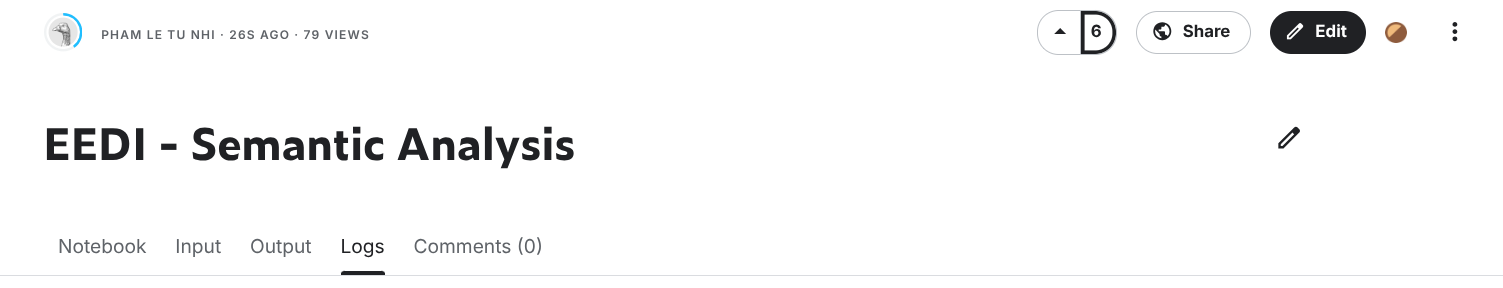

# 0. Data Pre-processing

Đầu tiên, chúng ta sẽ xử lí dữ liệu để thực hiện khám phá. Quá trình xử lí dữ liệu bao gồm việc chuyển đổi đơn vị dòng là câu hỏi trở thành một đáp án sai - ứng với một misconception. 

Các dữ liệu thiếu misconception sẽ bị loại bỏ.

In [1]:
# Import libs
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter
import plotly.express as px

In [2]:
# Read data
train_df = pd.read_csv('/kaggle/input/eedi-mining-misconceptions-in-mathematics/train.csv')
test_df = pd.read_csv('/kaggle/input/eedi-mining-misconceptions-in-mathematics/test.csv')
misconceptions = pd.read_csv('/kaggle/input/eedi-mining-misconceptions-in-mathematics/misconception_mapping.csv')

# Transform misconceptions of each option into rows
stacked_misconceptions = train_df[['QuestionId', 'SubjectName', 'ConstructName', 'CorrectAnswer', 'QuestionText', 
                                   'MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']].melt(
    id_vars=['QuestionId', 'SubjectName', 'ConstructName', 'CorrectAnswer', 'QuestionText'], 
    var_name='Choice', 
    value_name='Misconception'
).reset_index()
stacked_misconceptions['Choice'] = stacked_misconceptions['Choice'].str.replace('Misconception', '').str.replace('Id', '')

# Transform answer of each option into rows
stacked_answers = train_df[['QuestionId', 'SubjectName', 'ConstructName', 'CorrectAnswer', 'QuestionText', 
                            'AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText']].melt(
    id_vars=['QuestionId', 'SubjectName', 'ConstructName', 'CorrectAnswer', 'QuestionText'], 
    var_name='Choice', 
    value_name='Answer'
).reset_index()
stacked_answers['Choice'] = stacked_answers['Choice'].str.replace('Answer', '').str.replace('Text', '')

In [3]:
# Combine misconceptions and answers
stacked_df = pd.merge(left = stacked_misconceptions, right=stacked_answers).drop(columns=['index'])
stacked_df = stacked_df.dropna().reset_index(drop=True)

# Add Misconception description
misconception_df = pd.merge(left = stacked_df, right=misconceptions, left_on=['Misconception'], right_on='MisconceptionId')

In [4]:
# Some more pre-processing
misconception_df['SubjectName'] = misconception_df['SubjectName'].apply(lambda x: x.replace('BIDMAS', 'Brackets, Indices, Division, Multiplication, Addition, Subtraction'))
misconception_df['SubjectName'] = misconception_df['SubjectName'].apply(lambda x: str.lower(x))

In [5]:
misconception_df.head()

,QuestionId,SubjectName,ConstructName,CorrectAnswer,QuestionText,Choice,Misconception,Answer,MisconceptionId,MisconceptionName
0,1,simplifying algebraic fractions,Simplify an algebraic fraction by factorising ...,D,"Simplify the following, if possible: \( \frac{...",A,2142.0,\( m+1 \),2142,Does not know that to factorise a quadratic ex...
1,163,factorising into a double bracket,Factorise a quadratic expression in the form x...,C,When factorising \( x^{2}+5 x+6 \) we need two...,A,2142.0,Add to give \( 6 \) and multiply to give \( 5 \),2142,Does not know that to factorise a quadratic ex...
2,474,factorising into a double bracket,Factorise a quadratic expression in the form x...,C,Factorise the following expression \( x^{2}+6 ...,A,2142.0,\( (x+2)(x+3) \),2142,Does not know that to factorise a quadratic ex...
3,163,factorising into a double bracket,Factorise a quadratic expression in the form x...,C,When factorising \( x^{2}+5 x+6 \) we need two...,B,2142.0,Add to give \( 6 x \) and multiply to give \( ...,2142,Does not know that to factorise a quadratic ex...
4,1,simplifying algebraic fractions,Simplify an algebraic fraction by factorising ...,D,"Simplify the following, if possible: \( \frac{...",C,2142.0,\( m-1 \),2142,Does not know that to factorise a quadratic ex...


In [6]:
misconception_df['Misconception'].value_counts()

Misconception
1214.0    54
1379.0    43
2316.0    38
1507.0    36
1990.0    33
          ..
213.0      1
2128.0     1
1517.0     1
2476.0     1
95.0       1
Name: count, Length: 1604, dtype: int64

Lưu ý: Có một số hệ quả từ cách chúng ta làm sạch dữ liệu.
- Khi chúng ta đề cập đến tất cả các giá trị của Feature có mặt trong dữ liệu, ý chúng ta là các Feature chứa ít nhất một misconception ID không rỗng.

# 0.5 Intuition

Ý tưởng của phương pháp này đến từ quá trình nhóm sử dụng nhiều phương pháp để thực hiện phân cụm trên các môn học, chẳng hạn như:  
- **TFIDF encoding + k-mean clustering:** Kết quả rất không ổn định và không đại diện tốt cho dữ liệu hiện có.  
- **Language model embedding + k-mean clustering:** Kết quả phân cụm có ý nghĩa về mặt ngữ nghĩa, nhưng không cung cấp được chủ đề của cụm. Nhóm đã thử nghiệm sử dụng TFIDF để tìm chủ đề cho mỗi cụm nhưng đưa ra kết quả không tốt.   
- **LLM:** Cuối cũng nhóm có thực hiện thử nghiệm phân cụm với LLM. Phương pháp này chứng minh được tính chính xác cao và có ý nghĩa về mặt ngữ nghĩa.  

Cuối cùng, nhóm quyết định sử dụng LLM để thực hiện phân cụm ngữ nghĩa. Phương pháp này được áp dụng cho tất cả các cột dữ liệu trong notebook này.

Chi tiết các Prompts được sử dụng đối với phân tích mỗi trường dữ liệu được lưu ở mục `other-source-code`, với:
- Prompting ứng với phân tích `SubjectName`: `SubjectNamePrompting.json`
- Prompting ứng với phân tích `ConstructName`: `ConstructNamePrompting.json`
- Promting ứng với phân tích `Misconception`: `MisconceptionPrompting(1).json` và  `MisconceptionPrompting(2).json`

Note: Nguyên nhân nhóm cung cấp thông tin prompting qua file `.json` là vì nên tảng Claude Sonnet 3.5 chỉ cung cấp phương pháp export dữ liệu qua file `.json`.

## 1. Phân tích `SubjectName`
### 1.1 Cấu Trúc  

Chúng ta sẽ bắt đầu phân tích `SubjectName`. Mục tiêu của bước này là khám phá các chủ đề (như đại số, hình học...) xuất hiện trong tập dữ liệu. Đối với `SubjectName`, vì giới hạn của độ dài thông tin và số lượng subject, nhóm thực hiện cluster bằng cách upload trực tiếp danh sách tên các `SubjectName` trên interface của Claude Sonnet 3.5. 

In [7]:
print("Number of unique subjects:", misconception_df['SubjectName'].nunique())
print("Max length (in characters) of subjects:", max(misconception_df['SubjectName'].str.len()))
print("List of unique subjects:", misconception_df['SubjectName'].unique()[:10])

Number of unique subjects: 163
Max length (in characters) of subjects: 66
List of unique subjects: ['simplifying algebraic fractions' 'factorising into a double bracket'
 'range and interquartile range from a list of data'
 'properties of quadrilaterals' 'naming co-ordinates in 2d'
 'expanding single brackets' 'area of simple shapes' 'area units'
 'converting between fractions and percentages' 'percentages of an amount']


Để có được danh sách phân cụm, chúng ta đưa danh sách này vào LLM và yêu cầu thực hiện phân cụm ngữ nghĩa. Chi tiết về prompt có thể xem [tại đây](https://drive.google.com/file/d/1u1wvyWkiPQ6COM_bSlVj23I9wh1U_EWD/view?usp=drive_link).  

Trong quá trình prompting, kết quả đầu tiên thường không khớp với mong muốn của người thực hiện (nhóm) nên sẽ có sự trao đổi qua lại để có được một phiên bản phù hợp nhất. 

### 1.2 Kết quả  
Có 8 danh mục chính được khám phá từ tên các môn học:  
  - **`Number Operations`**: Bao gồm các bài toán về Phép tính cơ bản, Số âm, Số thập phân, Phân số, Phần trăm, Ước số và Bội số, Ước lượng.  
  - **`Algebra`**: Bao gồm các bài toán về Đại số cơ bản, Phương trình, Phân thức đại số, Dấu ngoặc, Phân tích đa thức.  
  - **`Geometry`**: Bao gồm các bài toán về Hình học 2 chiều, Hình học 3 chiều, Góc, Đường thẳng, Phép biến hình.  
  - **`Functions and Graphs`**: Bao gồm các bài toán về Hình học tọa độ, Hàm số tuyến tính, Hàm số phi tuyến.
  - **`Measurement`**: Bao gồm các bài toán về Độ dài và Diện tích, Thể tích, Tỷ lệ và Tỷ lệ tương ứng, Các đơn vị khác.  
  - **`Statistics and Data`**: Bao gồm các bài toán về Biểu diễn dữ liệu, Phân tích dữ liệu, Xác suất.  
  - **`Sequence and Pattern`**: Bao gồm các bài toán về Dãy số.  
  - **`Advanced Topics`**: Bao gồm các bài toán về Lượng giác, Định lý Pythagoras, Số mũ và Căn, Tỷ lệ, và các chủ đề nâng cao khác.

Dữ liệu sinh cũng có bao gồm các mục phụ là các chủ đề con nằm trong các chủ đề đã khám phá được từ tên môn học.

Nhìn chung, có thể thấy các bài toán trong tập dữ liệu thuộc trình độ Toán từ cấp Tiểu học đến Trung học cơ sở.

In [8]:
# The categorized list of subject
math_categories = {
    "Number Operations": {
        "Basic Operations": [
            "counting",
            "mental addition and subtraction",
            "mental multiplication and division",
            "written addition",
            "written subtraction",
            "written multiplication",
            "written division",
            "combining operations",
            "basic calculator use",
            "brackets, indices, division, multiplication, addition, subtraction",
            "place value"
        ],
        "Negative Numbers": [
            "ordering negative numbers",
            "adding and subtracting negative numbers",
            "multiplying and dividing negative numbers"
        ],
        "Decimals": [
            "adding and subtracting with decimals",
            "multiplying and dividing with decimals",
            "ordering decimals",
            "rounding to decimal places",
            "rounding to the nearest whole (10, 100, etc)",
            "rounding to significant figures",
            "converting between decimals and percentages"
        ],
        "Fractions": [
            "simplifying fractions",
            "equivalent fractions",
            "ordering fractions",
            "fractions of an amount",
            "adding and subtracting fractions",
            "multiplying fractions",
            "dividing fractions",
            "converting mixed number and improper fractions",
            "converting between fractions and decimals",
            "converting between fractions and percentages",
            "recurring decimals to fractions"
        ],
        "Percentages": [
            "percentages of an amount",
            "percentage increase and decrease"
        ],
        "Factors and Multiples": [
            "factors and highest common factor",
            "multiples and lowest common multiple"
        ],
        "Estimation": [
            "types, naming and estimating",
            "estimation"
        ]
    },
    "Algebra": {
        "Basic Algebra": [
            "writing expressions",
            "simplifying expressions by collecting like terms",
            "writing formula",
            "substitution into formula",
            "multiplying terms",
            "function machines"
        ],
        "Equations": [
            "linear equations",
            "rearranging formula and equations",
            "simultaneous equations",
            "quadratic equations",
            "solving linear inequalities",
            "solving quadratic inequalities",
            "trial and improvement and iterative methods"
        ],
        "Algebraic Fractions": [
            "simplifying algebraic fractions",
            "adding and subtracting algebraic fractions",
            "multiplying and dividing algebraic fractions"
        ],
        "Brackets and Factoring": [
            "expanding single brackets",
            "expanding double brackets",
            "expanding triple brackets and more",
            "factorising into a single bracket",
            "factorising into a double bracket",
            "difference of two squares"
        ]
    },
    "Geometry": {
        "2D Shapes": [
            "properties of triangles",
            "properties of quadrilaterals",
            "properties of polygons",
            "2d names and properties of shapes-others",
            "parts of a circle",
            "construct triangle"
        ],
        "3D Shapes": [
            "names and properties of 3d shapes",
            "nets"
        ],
        "Angles": [
            "measuring angles",
            "basic angle facts (straight line, opposite, around a point, etc)",
            "angles in triangles",
            "angles in polygons",
            "angle facts with parallel lines",
            "construct angle"
        ],
        "Lines": [
            "parallel lines",
            "perpendicular lines",
            "horizontal and vertical lines"
        ],
        "Transformations": [
            "translation and vectors",
            "reflection",
            "rotation",
            "enlargement",
            "line symmetry",
            "rotational symmetry"
        ]
    },
    "Measurement": {
        "Length and Area": [
            "length units",
            "perimeter",
            "area units",
            "area of simple shapes",
            "compound area",
            "missing lengths"
        ],
        "Volume": [
            "volume of prisms",
            "volume of non-prisms",
            "volume and capacity units",
            "surface area of prisms"
        ],
        "Scale and Proportion": [
            "length scale factors in similar shapes",
            "length, area and volume scale factors"
        ],
        "Other Units": [
            "time",
            "weight units",
            "temperature units",
            "basic money",
            "currency conversions"
        ]
    },
    "Statistics and Data": {
        "Data Representation": [
            "frequency tables",
            "pictogram",
            "block graphs and bar charts",
            "pie chart",
            "time series and line graphs",
            "types of data and questionnaires"
        ],
        "Data Analysis": [
            "averages (mean, median, mode) from a list of data",
            "range and interquartile range from a list of data",
            "averages and range from frequency table",
            "averages and range from grouped data"
        ],
        "Probability": [
            "probability of single events",
            "experimental probability and relative frequency",
            "combined events",
            "tree diagrams with dependent events",
            "systematic listing strategies"
        ]
    },
    "Functions and Graphs": {
        "Coordinate Geometry": [
            "naming co-ordinates in 2d",
            "distance between two co-ordinates",
            "midpoint between two co-ordinates",
            "co-ordinate geometry with straight lines"
        ],
        "Linear Functions": [
            "plotting lines from tables of values",
            "finding the equation of a line",
            "finding the gradient and intercept of a line from the equation",
            "gradient as change in y over change in x",
            "gradient between two co-ordinates",
            "straight line graphs-others"
        ],
        "Non-Linear Functions": [
            "plotting quadratics from tables of values",
            "quadratic graphs-others",
            "sketching from factorised form",
            "sketching from completing the square form",
            "graphs of exponentials and other powers of x",
            "cubics and reciprocals",
            "transformations of functions in the form f(x)",
            "equation of a circle",
            "real life graphs",
            "other graphs-others"
        ]
    },
    "Sequences and Pattern": {
        "Number Sequences": [
            "linear sequences (nth term)",
            "quadratic sequences",
            "other sequences",
            "sequences-others"
        ]
    },
    "Advanced Topics": {
        "Trigonometry": [
            "right-angled triangles (sohcahtoa)",
            "exact values of trigonometric ratios"
        ],
        "Pythagoras": [
            "2d pythagoras"
        ],
        "Indices and Surds": [
            "laws of indices",
            "square roots, cube roots, etc",
            "squares, cubes, etc",
            "simplifying surds",
            "operations with surds"
        ],
        "Proportion": [
            "direct proportion",
            "indirect (inverse) proportion",
            "sharing in a ratio",
            "writing ratios"
        ],
        "Other Advanced": [
            "standard form",
            "upper and lower bounds",
            "algebraic proof",
            "completing the square",
            "graphical solution of simultaneous equations",
            "graphing linear inequalities (shading regions)",
            "quadratic inequalities on number lines",
            "inequalities on number lines",
            "venn diagrams",
            "bearings",
            "congruency in other shapes",
            "speed, distance, time"
        ]
    }
}
topic_to_category = {}
topic_to_subcategory = {}

# Function to find the corresponding category for a topic
for category, subcats in math_categories.items():
    for subcat, topics in subcats.items():
        for topic in topics:
            topic_to_category[topic] = category
            topic_to_subcategory[topic] = subcat

# Then use with pandas
misconception_df['SubjectMainCategory'] = misconception_df['SubjectName'].map(topic_to_category)
misconception_df['SubjectSubCategory'] = misconception_df['SubjectName'].map(topic_to_subcategory)

In [9]:
misconception_df.head()

,QuestionId,SubjectName,ConstructName,CorrectAnswer,QuestionText,Choice,Misconception,Answer,MisconceptionId,MisconceptionName,SubjectMainCategory,SubjectSubCategory
0,1,simplifying algebraic fractions,Simplify an algebraic fraction by factorising ...,D,"Simplify the following, if possible: \( \frac{...",A,2142.0,\( m+1 \),2142,Does not know that to factorise a quadratic ex...,Algebra,Algebraic Fractions
1,163,factorising into a double bracket,Factorise a quadratic expression in the form x...,C,When factorising \( x^{2}+5 x+6 \) we need two...,A,2142.0,Add to give \( 6 \) and multiply to give \( 5 \),2142,Does not know that to factorise a quadratic ex...,Algebra,Brackets and Factoring
2,474,factorising into a double bracket,Factorise a quadratic expression in the form x...,C,Factorise the following expression \( x^{2}+6 ...,A,2142.0,\( (x+2)(x+3) \),2142,Does not know that to factorise a quadratic ex...,Algebra,Brackets and Factoring
3,163,factorising into a double bracket,Factorise a quadratic expression in the form x...,C,When factorising \( x^{2}+5 x+6 \) we need two...,B,2142.0,Add to give \( 6 x \) and multiply to give \( ...,2142,Does not know that to factorise a quadratic ex...,Algebra,Brackets and Factoring
4,1,simplifying algebraic fractions,Simplify an algebraic fraction by factorising ...,D,"Simplify the following, if possible: \( \frac{...",C,2142.0,\( m-1 \),2142,Does not know that to factorise a quadratic ex...,Algebra,Algebraic Fractions


### 1.2 Data Analysis

Chúng ta đi vào thực hiện phân tích dữ liệu. 

Đầu tiên, hay xem xét các phân phối cơ bản của dữ liệu mới sinh - chủ đề toán học của các câu hỏi. 

**Phân phối của `SubjectMainCategory` theo số lượng câu hỏi là gì?**


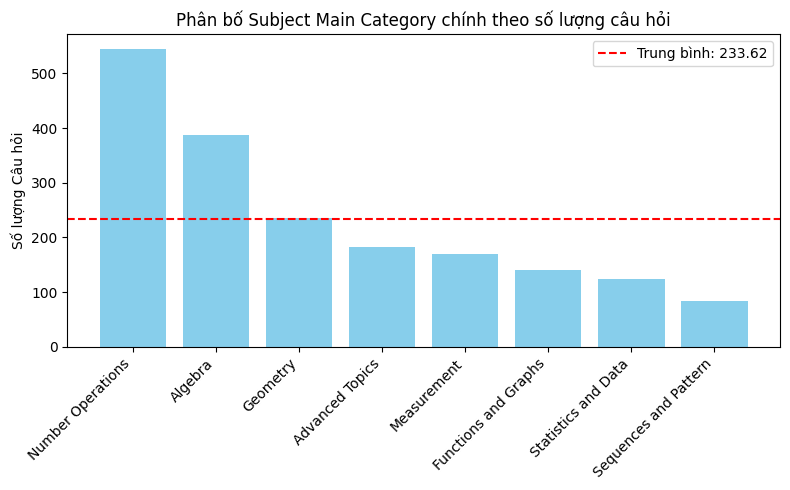

In [10]:
# Group and calculate the distribution
subject_theme_dist = misconception_df.groupby(['SubjectMainCategory'])['QuestionId'].nunique().sort_values(ascending=False)

# Calculate the mean
mean_value = subject_theme_dist.mean()

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.title("Phân bố Subject Main Category chính theo số lượng câu hỏi")
plt.bar(subject_theme_dist.index, subject_theme_dist, color='skyblue')

# Add a mean line
plt.axhline(mean_value, color='red', linestyle='--', linewidth=1.5, label=f'Trung bình: {mean_value:.2f}')

# Add labels and legend
plt.xticks(rotation=45, ha='right')
plt.ylabel("Số lượng Câu hỏi")
plt.legend()
plt.tight_layout()


*Nhận xét:*
- Chủ đề phổ biến nhất là `Number Operations`. Điều này có thể chỉ ra rằng phần lớn các môn học trong tập dữ liệu thuộc cấp độ Toán Tiểu học.
- `Number Operations` và `Algebra` chiếm khoảng một nửa số `QuestionId` có trong tập dữ liệu.
- `Sequence and Pattern` chứa ít nhất số lượng `QuestionId`, với chưa đến 100 câu hỏi trong tập dữ liệu.1. 

**Các chủ đề phụ (`SubjectSubCategory`) được phân phối trong mỗi `SubjectMainCategory` như thế nào?**

In [ ]:
# Import required libraries if not already imported
import seaborn as sns
import matplotlib.pyplot as plt

# Group the data to get counts of QuestionId within each main and subcategory
category_counts = (
    misconception_df.groupby(['SubjectMainCategory', 'SubjectSubCategory'])['QuestionId']
    .count()
    .reset_index(name='Count')
)

# Get unique main categories
main_categories = misconception_df['SubjectMainCategory'].unique()

# Calculate number of rows and columns for subplots
n_categories = len(main_categories)
n_cols = 2
n_rows = (n_categories + 1) // 2  # Ceiling division to ensure enough rows

# Create figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()  # Flatten axes array for easier indexing
palette = sns.color_palette("husl", n_colors=n_categories)

# Create a bar plot for each main category
for idx, main_cat in enumerate(main_categories):
    # Get data for this category
    cat_data = category_counts[category_counts['SubjectMainCategory'] == main_cat]
    # Sort the data by 'Count' in descending order
    cat_data = cat_data.sort_values(by='Count', ascending=False)

    # Create bar plot
    sns.barplot(
        data=cat_data,
        x='SubjectSubCategory',
        y='Count',
        ax=axes[idx],
        color=palette[idx]  # Use the generated palette
    )
    
    # Customize subplot
    axes[idx].set_title(f'Phân bố chủ đề phụ của: {main_cat}')  # Translated title
    axes[idx].set_xlabel('Chủ đề phụ')  # Translated x-axis label
    axes[idx].set_ylabel('Số lượng')  # Translated y-axis label
    
    # Rotate x-axis labels for better readability
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), ha='right')
    
    # Add value labels on top of bars
    for i, v in enumerate(cat_data['Count']):
        axes[idx].text(i, v, str(v), ha='center', va='bottom')
    
    # Add grid
    # axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

# Remove any empty subplots
for idx in range(len(main_categories), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

*Nhận xét:*
- Các `SubjectSubCategory` có phân bố tỉ lệ không đồng đều, với một số chủ đề phụ (thường là 1 đến 2) bao gồm phần lớn các câu hỏi thuộc mỗi chủ đề chính.
- `Number Operations` là chủ đề có nhiều chủ đề phụ nhất với 6 `SubjectSubCategory`
- 'Sequence and Pattern` là chủ đề có ít chủ đề phụ nhất với 1 `SubjectSubCategory`
- Về số lượng, 5 chủ đề phụ có số lượng lớn nhất là:
    - `Number Operations` - `Basic Operations`: 381
    - `Number Operations` - `Decimals`: 317
    - `Number Operations` - `Fractions`: 317
    - `Algebra` - `Equations`: 308
    - `Algebra` - `Basic Algebra`: 294  

-> Phản ánh tỉ lệ các chủ đề chính mà chúng ta đã khám phá. Số lượng các chủ đề liên quan đến tính toán với số có tỉ lệ xuất hiện cao. 

Đối với từng `SubjectMainCategory`:
1. `Algebra`:
- Có 4 chủ đề con là `Equation` (Phương trình), `Basic Algebra` (Đại số cơ bản), `Bracket and Factoring` (Bài toán về ngoặc và phân tích thành nhân tử) và `Algebraic Fractions`(phân số đại số)
- Chủ đề phụ về Phương trình có tỉ lệ xuất hiện cao nhất, và các chủ đề phụ về Đại số cơ bản có số lượt ít hơn xấp xỉ. 

2. `Statistic and Data`:
- Có 3 chủ đề con là `Data Analysis` (Phân tích dữ liệu), `Data Representation` (Biểu diễn dữ liệu) và `Probability` (Sác xuất)
- Chủ đề phụ về Phân tích dữ liệu có tỉ lệ xuất hiện cao nhất, và chủ đề về Biểu diễn dữ liệu có số lượng ít hơn xấp xỉ.

3. `Geometry`:
- Có 5 chủ đề con là `Angles` (Góc cạnh), `Transformation` (Biến đổi hình học), `2D shapes` (Hình học 2 chiều), `Lines` (Đường thẳng) và `3D shapes` (Hình học 3 chiều)
- Chủ đề phụ về Góc cạnh có tỉ lệ xuất hiện cao nhất. Chủ đề về Hình học 3 chiều là ít nhất.

4. `Functions and Graphs`:
- Có 3 chủ đề con là `Non-Linear Function` (Phương trình phi tuyến), `Linear Function` (Phương trình tuyến tính) và `Coordinate geometry` (Hình học tọa độ)
- Chủ đề phụ về Phương trình phi tuyến có tỉ lệ xuất hiện cao nhất. Chủ đề về Hình học tọa độ là ít nhất.

5. `Measurement`:
- Có 4 chủ đề con là `Length and Area` (Chiều dài và diện tích), `Volume` (Thể tích), `Other Units` (Các đơn vị đo khác) và `Scale and proportion` (Quy mô và tỉ lệ)
- Chủ đề phụ về Chiều dài và diện tích có tỉ lệ xuất hiện cao nhất. Chủ đề về Quy mô và tỉ lệ là thấp nhất (dưới 30 câu hỏi)

6. `Number Operation`
- Có 6 chủ đề con là `Basic Operation` (Phép toán cơ bản), `Fraction` (Phân số), `Decimal`(Số thập phân), `Negitive numbers` (Số âm), `Estimation` (Ước lượng), `Percentage` (Phần trăm), `Factors and multiplies` (Thừa số và bội số)
- Các chủ đề chia ra phân bố khá đồng đều: Một nửa có số lần xuất hiện cao sấp xỉ nhau (Phép toán cơ bản, Phân số, Số thập phân) và một nữa có số luần xuất hiện thấp sấp xỉ nhau (Số âm, Ước lượng, Phần trăm, Thừa số và bội số)

7. `Advanced topics`
- Có 5 chủ đề con là `Indicies and Surds` (Chỉ số và căn thức), `Other advanced` (Các bài toán nâng cao khác), `Propotion` (Tỉ lệ), `Trigonometry` (Đại số lượng giác) và `Pythagoras` (Các bài toán liên quan đến Pytago)
- Chủ đề về Chỉ số và căn thức có số lần xuất hiện nhiều nhất. Các bài toán về Pytago xuất hiện ít nhất với chỉ 1 bài toán.

**Sự liên quan giữa số lượng `QuestionId` của một `SubjectMainCategory` và số lượng `Misconception` là gì?**

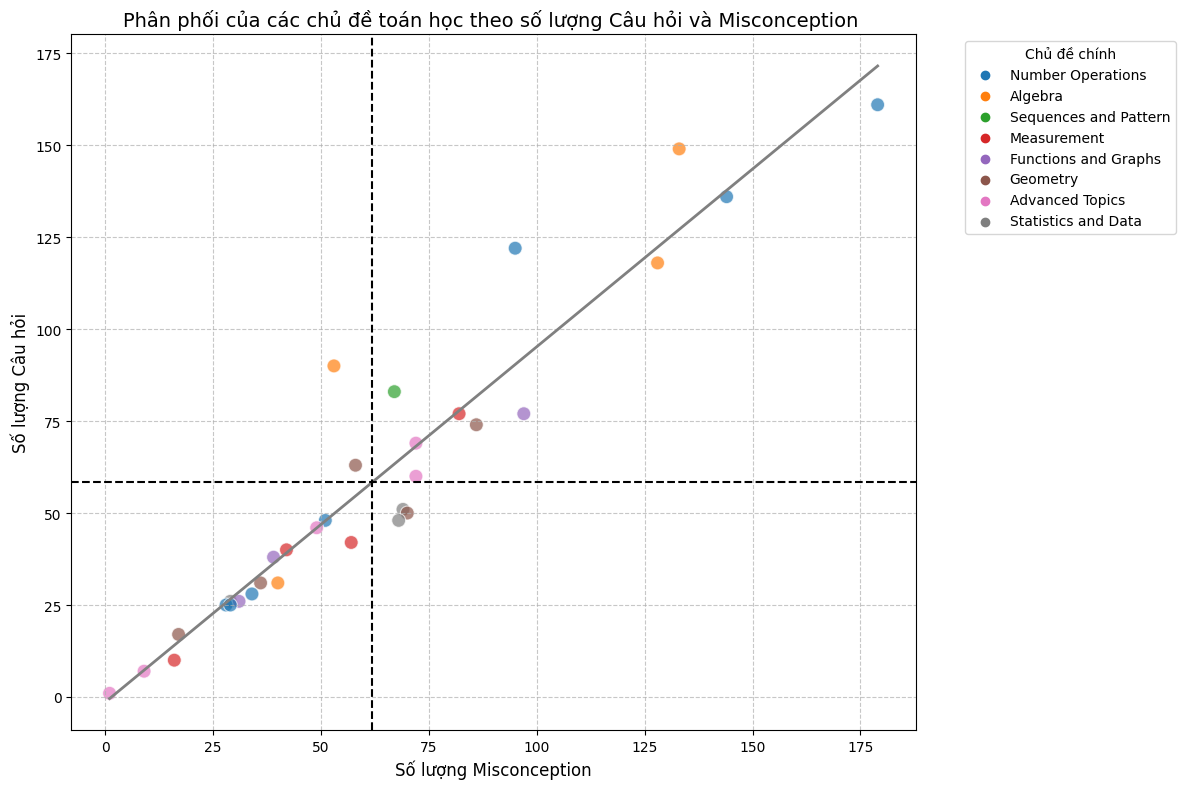

In [12]:
# Group the data and calculate the unique counts
grouped_data = misconception_df.groupby(['SubjectMainCategory', 'SubjectSubCategory']).nunique()[['QuestionId', 'MisconceptionId', 'ConstructName']]

# Sort values by 'QuestionId' in descending order
sorted_data = grouped_data.sort_values(by='QuestionId', ascending=False)

# Reset index to include 'SubjectMainCategory' in the plot
sorted_data = sorted_data.reset_index()

# Extract columns for the scatter plot
x = sorted_data['MisconceptionId']
y = sorted_data['QuestionId']
categories = sorted_data['SubjectMainCategory']

# Calculate means for the x and y axes
mean_x = x.mean()
mean_y = y.mean()

# Set color palette for SubjectMainCategory
palette = sns.color_palette("tab10", n_colors=len(categories.unique()))

# Create scatter plot with color coding by SubjectMainCategory
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=x,
    y=y,
    hue=categories,
    palette=palette,  # Use color palette for hue
    alpha=0.7,
    s=100  # Size of the scatter points
)

# Add regression line (use Seaborn's regplot without hue, overlayed)
sns.regplot(
    x=x,
    y=y,
    scatter=False,  # No scatter points, just the regression line
    line_kws={'color': 'grey', 'lw': 2},  # Customize the regression line
    ci=None  # Disable the confidence interval shading
)

# Add mean lines
plt.axvline(x=mean_x, color='black', linestyle='--')
plt.axhline(y=mean_y, color='black', linestyle='--')

# Add labels and title in Vietnamese
plt.xlabel('Số lượng Misconception', fontsize=12)  # X-axis label
plt.ylabel('Số lượng Câu hỏi', fontsize=12)  # Y-axis label
plt.title('Phân phối của các chủ đề toán học theo số lượng Câu hỏi và Misconception ', fontsize=14)  # Title

# Adjust legend
plt.legend(title='Chủ đề chính', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


> Các đường màu xám phía trên là đường hồi quy tuyến tính được điều chỉnh cho các điểm trong đồ thị.  
> Đường chấm ngang đại diện cho đường trung bình của số lượng `Misconception`.   
> Đường chấm dọc đại diện cho đường trung bình của số lượng `QuestionId`. 

*Nhận xét:*
- Các điểm có hướng theo một đường tuyến tính. Điều này có nghĩa là đối với hầu hết các `SubjectMainCategory`, việc có nhiều `QuestionId` hơn cũng liên quan đến việc có nhiều loại `Misconception` hơn. Điều này cho thấy số lượng câu hỏi có thể đại diện cho sự đa dạng của các vấn đề trong từng danh mục - điều này liên quan đến các quan niệm sai lầm cụ thể cho từng câu hỏi.
- Bằng cách phân chia phân phối dựa trên các đường trung bình của trục x và y, ta có thể chia nó thành bốn phần tư:
    - Phần tư trên bên phải đại diện cho các điểm có số lượng câu hỏi và quan niệm sai lầm lớn nhất.
    - Phần tư dưới bên trái đại diện cho các điểm có số lượng câu hỏi và quan niệm sai lầm ít nhất.
    - Phần tư trên bên trái đại diện cho các điểm có số lượng câu hỏi cao hơn nhưng ít quan niệm sai lầm hơn.
    - Phần tư dưới bên phải đại diện cho các điểm có số lượng câu hỏi nhỏ hơn.
- **Number Operations** và **Algebra** có sự phân bố khá rộng - với các điểm nằm ở cả phần tư trên bên phải và phần tư dưới bên trái.
- Các danh mục khác ít phân tán hơn - tập trung xung quanh phía bên trái của giao điểm đường trung bình x-y.

**Có bao nhiêu `Misconception` chỉ xuất hiện trong 1 `SubjectMainCategory`? Nhiều hơn 1 `SubjectMainCategory`?**

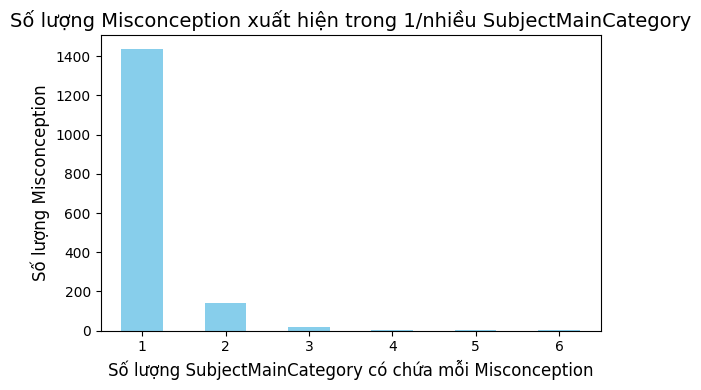

In [13]:
# Group by 'MisconceptionName' and count unique 'SubjectMainCategory' values
main_category_counts = misconception_df.groupby(['MisconceptionName'])['SubjectMainCategory'].nunique()

# Count the number of misconceptions for each unique 'SubjectMainCategory' count
main_category_distribution = main_category_counts.value_counts().sort_index()

# Plot the results
plt.figure(figsize=(6, 4))
main_category_distribution.plot(kind='bar', color='skyblue')

# Add labels and title in Vietnamese
plt.xlabel('Số lượng SubjectMainCategory có chứa mỗi Misconception', fontsize=12)  # X-axis label
plt.ylabel('Số lượng Misconception', fontsize=12)  # Y-axis label
plt.title('Số lượng Misconception xuất hiện trong 1/nhiều SubjectMainCategory', fontsize=14)  # Title
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability

# Display the plot
plt.tight_layout()
plt.show()


*Nhận xét:*
- Phần lớn các quan niệm sai lầm chỉ thuộc về 1 `SubjectMainCategory` (> 1400 `Míconceptions` ~ 78%).
- Số lượng `SubjectMainCategory` cao nhất mà một `Misconception` có thể thuộc về là 6.

**Phân phối tỷ lệ của `Misconceptions` chỉ thuộc 1 `SubjectMainCategory`trong các mục cụ thể là gì?**

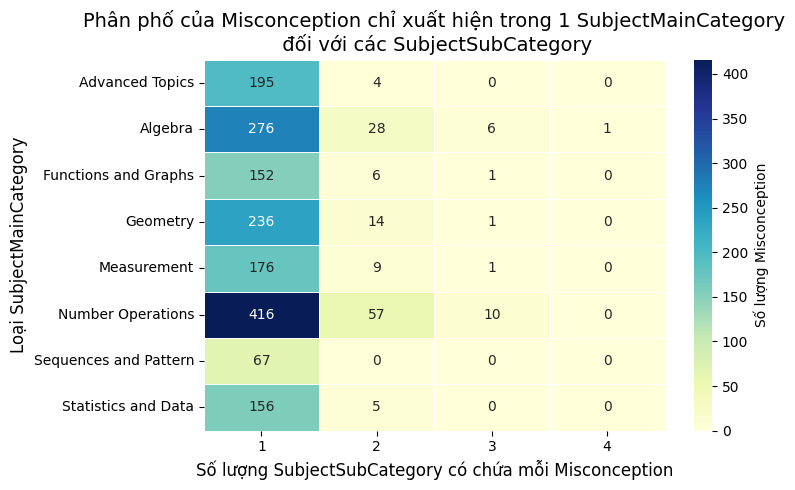

In [14]:
# Step 1: Group by 'MisconceptionName' and 'SubjectMainCategory', and count unique 'SubjectSubCategory' values
misconception_subcategory_count = misconception_df.groupby(['MisconceptionName', 'SubjectMainCategory'])['SubjectSubCategory'].nunique().reset_index()

# Step 2: Create a pivot table where rows are 'SubjectMainCategory', columns are the number of unique 'SubjectSubCategory' values
subcategory_counts_pivot = misconception_subcategory_count.groupby(['SubjectMainCategory', 'SubjectSubCategory']).size().unstack(fill_value=0)

# Step 3: Plot the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(subcategory_counts_pivot, annot=True, cmap='YlGnBu', fmt='d', cbar_kws={'label': 'Số lượng Misconception'}, linewidths=0.5)

# Add labels and title in Vietnamese
plt.xlabel('Số lượng SubjectSubCategory có chứa mỗi Misconception', fontsize=12)  # X-axis label
plt.ylabel('Loại SubjectMainCategory', fontsize=12)  # Y-axis label
plt.title('Phân phố của Misconception chỉ xuất hiện trong 1 SubjectMainCategory\n đối với các SubjectSubCategory', fontsize=14)  # Title

# Show plot
plt.tight_layout()
plt.show()


*Nhận xét:*
- Phần lớn các `Misconceptions` chỉ xuất hiện trong 1 `SubjectSubCategory`.
- `Algebra` là chủ đề duy nhất có `Misconception` xuất hiện ở cả 4 `SubjectSubCategory`
- `Number Operations`, `Measurement`, `Geometry`, `Functions and Graphs` có `Misconception` xuất hiện ở 3 `SubjectSubCategory`. Trong đó, `Measurement`, `Geometry`, `Functions and Graphs` chỉ có 1 `Míconception` chung cho 3 chủ đề phụ.
- `Statics and Data`, `Advanced Topics` có `Misconception` xuất hiện ở 2 `SubjectSubCategory`

**Các kết hợp phổ biến nhất của `Misconception` thuộc về 2 `Subject`là gì?**


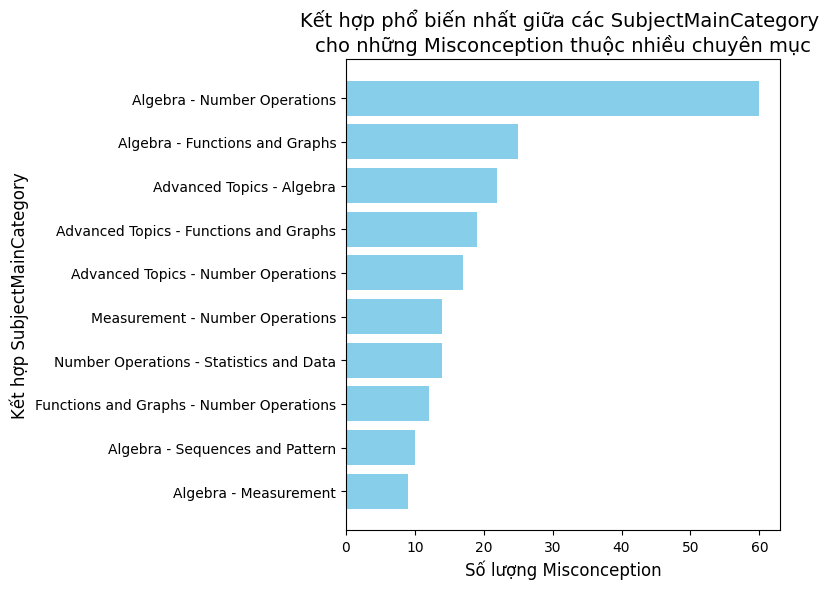

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

# Step 1: Group by 'MisconceptionName' and count unique 'SubjectMainCategory' values
misconception_category_count = misconception_df.groupby(['MisconceptionName', 'SubjectMainCategory']).size().reset_index()

# Step 2: Find misconceptions that fall into more than one 'SubjectMainCategory'
misconception_multiple_categories = misconception_category_count.groupby('MisconceptionName')['SubjectMainCategory'].nunique()
misconceptions_multiple_categories = misconception_multiple_categories[misconception_multiple_categories > 1]

# Step 3: Get all combinations of 'SubjectMainCategory' for misconceptions that fall into multiple categories
# Create a dictionary of misconceptions and their corresponding main category combinations
combinations_dict = {}
for misconception in misconceptions_multiple_categories.index:
    categories = misconception_df[misconception_df['MisconceptionName'] == misconception]['SubjectMainCategory'].unique()
    combinations_dict[misconception] = combinations(sorted(categories), 2)

# Step 4: Flatten the combinations and count the occurrences of each pair
pair_counts = Counter()
for combo_list in combinations_dict.values():
    for combo in combo_list:
        pair_counts[combo] += 1

# Step 5: Plot the most common combinations
# Get the most common combinations
common_combinations = pair_counts.most_common(10)

# Prepare data for plotting
combos, counts = zip(*common_combinations)
combo_labels = [f"{combo[0]} - {combo[1]}" for combo in combos]

# Create a DataFrame for sorting and plotting
misc_combo_pairs = pd.DataFrame({'labels': combo_labels, 'count': counts}).sort_values(by='count')

# Step 6: Plot
plt.figure(figsize=(8, 6))
plt.barh(misc_combo_pairs['labels'], misc_combo_pairs['count'], color='skyblue')

# Translated labels and title
plt.xlabel('Số lượng Misconception', fontsize=12)  # X-axis: Count of Misconceptions
plt.ylabel('Kết hợp SubjectMainCategory', fontsize=12)  # Y-axis: Main Category Combinations
plt.title('Kết hợp phổ biến nhất giữa các SubjectMainCategory \ncho những Misconception thuộc nhiều chuyên mục', fontsize=14)  # Title

plt.tight_layout()
plt.show()


*Nhận xét:*
- Cặp kết hợp phổ biến nhất là `Algebra` và `Number Operations`. Lưu ý rằng đây cũng là hai `SubjectMainCategory` phổ biến nhất trong tập dữ liệu.  
- `Algebra` có khả năng cao nhất chứa các `Misconception` giao thoa với các danh mục khác, xét theo số lượng.

### 1.3 Insights
- Nhận thấy các chủ đề có trong bộ dữ liệu train tập trung vào các chủ đề toán từ bậc tiểu học (`Number Operation`, `Measurement`) đến bậc trung học cơ sở (các chủ đề khác).
- Chủ đề phổ biến nhất là `Number Operation` (Thao tác số học) và `Algebra` (Đại số)
- Số lượng `Question` và `Misconception` của mỗi chủ đề toán học có tỉ lệ thuận (~tuyến tính)
- Đa số các `Misconception` chỉ thuộc về một chủ đề duy nhất.
- Trong các `Misconception` chỉ thuộc về một chủ đề, đa số các `Misconception` chỉ thuộc một chủ đề phụ duy nhất. Điều này cho thấy các `Misconception` thường rất cụ thể cho một bối cảnh cụ thể.
- Trong các `Misconception` thuộc về 2 chủ đề thì đa số các cặp giao chủ đề thường là các chủ đề phổ biển. (`Number Operation` ~ `Algebra`)


## 2. Phân tích `ConstructName`   
### 2.1 Cấu trúc

Sau khi đọc ki dữ liệu, nhóm nhận thấy rằng `ConstructName` có một cấu trúc rõ ràng. Nhóm xác định được cấu trúc gồm **3** phần như sau:  

- **Phần đầu tiên** là một động từ, biểu thị hành động cần thực hiện. Phần này gọi là `action word`.  
- **Phần thứ hai** mô tả đối tượng cần đạt được sau khi thực hiện hành động. Phần này gọi là `subject`.  
- **Phần cuối cùng** mô tả ngữ cảnh diễn ra hành động. Phần này gọi là `context`.  

### Ví dụ:  
Hãy cùng phân tích ví dụ sau:  

> Calculate the range from a list of data  

Chúng ta có thể chia nhỏ như sau:  
- **`action word`**: Calculate  
- **`subject`**: range  
- **`context`**: list of data  


Chúng ta sẽ sử dụng `Action word` của `Construct` để phân tích dữ liệu. Để thực hiện điều này, nhóm lấy danh sách 3 từ đầu tiên của mỗi `ConstructName` và tải vào mô hình LLM để thực hiện phân tích dữ liệu. 

In [16]:
# misconception_df['ConstructName'].apply(lambda x: ' '.join(x.split()[:3])).unique()

### # 2.2 Kết quả  
Có 8 danh mục chính được khám phá từ tên các cấu trúc:  
  - **`Direct Actions`**: Hành động đơn giản, trực tiếp. Ví du: Cộng hai số; Đếm các số trong dãy...
  - **`Transformative Actions`**: Hành động yêu cầu biến đổi một đối tượng. Ví dụ: Chuyển đổi phân số sang số thực; Làm tròn số,...
  - **`Analytical Actions`**: Hành động yêu cầu đánh giá, phân tích. Ví dụ: Nhận diện tam giác, số bình phương; Sắp xếp số theo một trình tự nào đó... 
  - **`Complex Actions`**: Hành động nhiều bước hoặc trừu tượng. Ví dụ: Chứng minh mệnh đề; Rút gọn biểu thức đại số...
  - **`Interpretive Actions`**: Hành động yêu cầu sự hiểu/giải thích. Ví dụ: Miêu tả một bài giải; Giải thích biểu đồ tròn...
  - **`Process Actions`**: Hành động thực hiện theo quy trình. Ví dụ: Sử dụng hướng dẫn để thực hiện...; Sử dụng kiến thức về ... để thực hiện...   
  - **`Generative Actions`**: Hành động yêu cầu sáng tạo. Ví dụ: Vẽ biểu đồ; Tạo pictogram...
  - **`Other`**: Hành động có ý nghĩa nội dung không phân chia rõ được vào các mục trên

In [17]:
# Get the list of 3-grams of ConstructName 
# misconception_df['ConstructName'].apply(lambda x : ' '.join(x.split()[:3])).unique()

In [18]:
# First, define the dictionary and function
MATH_ACTION_CATEGORIES = {
    # Direct Actions (Simple, One-Step Commands)
    'calculate': 'Direct Actions',
    'find': 'Direct Actions',
    'write': 'Direct Actions',
    'draw': 'Direct Actions',
    'read': 'Direct Actions',
    'add': 'Direct Actions',
    'subtract': 'Direct Actions',
    'multiply': 'Direct Actions',
    'divide': 'Direct Actions',
    'count': 'Direct Actions',
    'state': 'Direct Actions',
    'tell': 'Direct Actions',
    'mark': 'Direct Actions',
    'work': 'Direct Actions',
    
    # Transformative Actions
    'convert': 'Transformative Actions',
    'change': 'Transformative Actions',
    'express': 'Transformative Actions',
    'translate': 'Transformative Actions',
    'rotate': 'Transformative Actions',
    'reflect': 'Transformative Actions',
    'enlarge': 'Transformative Actions',
    'round': 'Transformative Actions',
    'raise': 'Transformative Actions',
    'substitute': 'Transformative Actions',
    
    # Analytical Actions
    'identify': 'Analytical Actions',
    'recognise': 'Analytical Actions',
    'recognize': 'Analytical Actions',
    'compare': 'Analytical Actions',
    'estimate': 'Analytical Actions',
    'order': 'Analytical Actions',
    'determine': 'Analytical Actions',
    'distinguish': 'Analytical Actions',
    'match': 'Analytical Actions',
    'prove': 'Analytical Actions',
    
    # Complex Actions
    'solve': 'Complex Actions',
    'construct': 'Complex Actions',
    'rearrange': 'Complex Actions',
    'simplify': 'Complex Actions',
    'expand': 'Complex Actions',
    'factorise': 'Complex Actions',
    'factorize': 'Complex Actions',
    'manipulate': 'Complex Actions',
    
    # Interpretive Actions
    'interpret': 'Interpretive Actions',
    'understand': 'Interpretive Actions',
    'describe': 'Interpretive Actions',
    'explain': 'Interpretive Actions',
    'know': 'Interpretive Actions',
    'recall': 'Interpretive Actions',
    
    # Process Actions
    'use': 'Process Actions',
    'follow': 'Process Actions',
    'perform': 'Process Actions',
    'carry': 'Process Actions',
    'complete': 'Process Actions',
    'continue': 'Process Actions',
    
    # Generative Actions
    'create': 'Generative Actions',
    'generate': 'Generative Actions',
    'plot': 'Generative Actions',
    'label': 'Generative Actions',
    'shade': 'Generative Actions',
    'construct': 'Generative Actions',
}

def categorize_math_action(text):
    # Handle empty or non-string input
    if not isinstance(text, str) or not text.strip():
        return 'Unknown'
    
    # Get the first word (assumed to be the action verb)
    first_word = text.lower().split()[0]
    
    # Special handling for multi-word verbs
    if first_word == 'carry' and 'out' in text.lower():
        return 'Process Actions'
    if first_word == 'work' and 'out' in text.lower():
        return 'Direct Actions'
    
    # Return the category if found, otherwise return 'Other'
    return MATH_ACTION_CATEGORIES.get(first_word, 'Other')

In [19]:
# Import the functions and dictionary from previous code
misconception_df['ConstructActionType'] = misconception_df['ConstructName'].apply(categorize_math_action)

### 2.2 Data Analysis

**Phân phối của `Construct Action` theo `Question` là gì?**

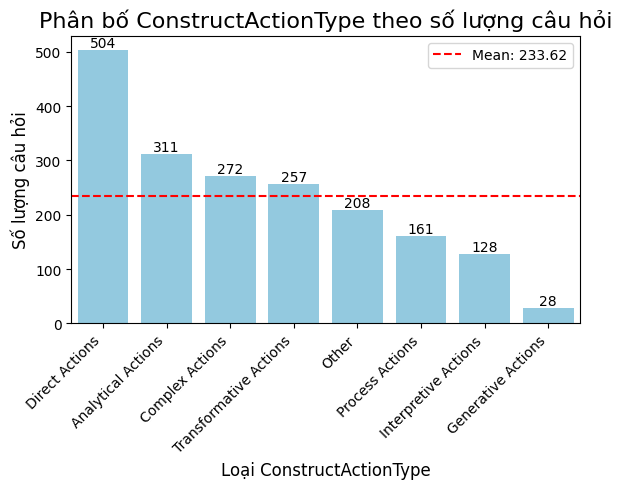

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count unique QuestionId values for each ConstructActionType
action_type_counts = (
    misconception_df.groupby('ConstructActionType')['QuestionId']
    .nunique()
    .reset_index()
    .rename(columns={'QuestionId': 'UniqueQuestionCount'})
)

# Sort the data by unique question count in descending order
action_type_counts = action_type_counts.sort_values(by='UniqueQuestionCount', ascending=False)

# Calculate the mean UniqueQuestionCount
mean_value = action_type_counts['UniqueQuestionCount'].mean()

# Set figure size
plt.figure(figsize=(6, 5))

# Create the bar plot
sns.barplot(
    data=action_type_counts,
    x='ConstructActionType',
    y='UniqueQuestionCount',
    color='skyblue'
)

# Add the mean line
plt.axhline(y=mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')

# Customize the plot
plt.title('Phân bố ConstructActionType theo số lượng câu hỏi', fontsize=16)
plt.xlabel('Loại ConstructActionType', fontsize=12)
plt.ylabel('Số lượng câu hỏi', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for i, row in enumerate(action_type_counts.itertuples()):
    plt.text(i, row.UniqueQuestionCount, str(row.UniqueQuestionCount), ha='center', va='bottom', fontsize=10)

# Add grid lines
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend for the mean line
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


*Nhận xét:*
- `Construct Action` phổ biến nhất là `Direct Actions`, `Analytical Actions` và `Complex Actions`.
- `Construct Action` ít phổ biến nhất là `Generative Actions` với chỉ 28 instances.
- Dựa vào đường trung bình, ta có thể phân chia các `Construct Action` thành 2 nhóm:
    - Nhóm nửa trên trung bình: `Direct Action`, `Analytical Actions`, `Complex Actions`, `Transformative Actions`
    - Nhóm nửa dưới trung bình: `Other`, `Process Actions`, `Interpretive Actions`, `Generative Actions`

**Phân phối của `ConstructActionType` theo `SubjectMainCategory` là gì?**

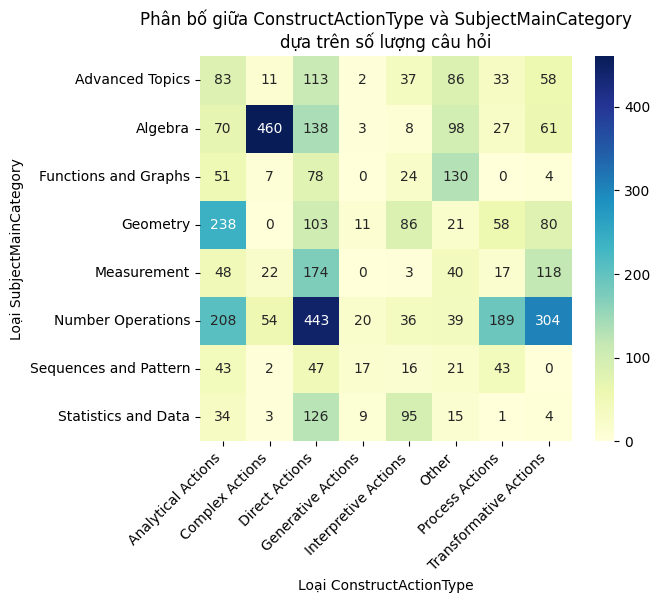

In [21]:
# Create a pivot table aggregating counts of QuestionId
pivot_table = misconception_df.pivot_table(
    values='QuestionId',  # Column to aggregate
    columns='ConstructActionType',
    index='SubjectMainCategory',
    aggfunc='count',  # Count non-null QuestionId entries
    fill_value=0
)

# Create a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Phân bố giữa ConstructActionType và SubjectMainCategory\ndựa trên số lượng câu hỏi')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Loại ConstructActionType')
plt.ylabel('Loại SubjectMainCategory')
plt.show()


*Nhận xét:*
- Có những `Construct Actions` chủ yếu xuất hiện trong một loại `SubjectCategory` duy nhất: `Complex Actions` trong `Algebra`; `Transformative Actions`, `Process Actions` trong `Number Operations`
- Có những `Construct Actions` xuất hiện trong nhiều `SubjectCategory`: `Direct Actions` trong `Number Operations`, `Measurement`, `Statistics and Data`, `Algebra`; `Analytical Actions` trong `Number Operations` và `Geometry`. Đây cũng là hai `Construct Actions` phổ biến nhất và thứ hai.
- Có những `Construct Actions` hiếm khi xuất hiện: `Generative Actions`.
- `Number Operations` có tập hợp các `Construct Actions` tập trung nhất.
- `Sequence and Pattern` có tập hợp các `Construct Actions` phân tán nhất.

Phân tích theo `Construct Action`:
- `Direct Actions`: Được sử dụng nhiều nhất trong `Number Operations` nhưng cũng được sử dụng nhiều trong các chủ đề khác. Điều này có thể cho thấy rằng dạng bài này đại diện một phần cho các dạng câu hỏi **đơn giản**, **cơ bản** hơn của các chủ đề toán học.
- `Analytical Actions`: Được sử dụng nhiều trong chủ đề `Geometry` và `Number Operation`. Điều này có thể cho thấy rằng so với các chủ đề khác thì Hình học và Tính toán với số yêu cầu đánh giá, **nhận diện** mẫu nhiều hơn so với các chủ đề khác.
- `Complex Actions`: Được hầu hết sử dụng trong `Algebra`. Điều này có thể cho thấy rằng các bài toán thuộc `Algebra` có sác xuất yêu cầu người học phải hiểu các ý tưởng **trừu trượng**, **thực hiện nhiều bước** hơn so với các chủ đề toán khác.
- `Transformative Actions`: Được sử dụng hầu hết trong chủ đề về `Number Operations` và hầu hết không được sử dụng trong `Sequence and Pattern`, `Statistics and Data`, `Function and Graph`. Điều này có thể thể cho thấy trằng đối với các chủ đề không sử dụng nhiều dạng bài này không có cấu trúc của đối tượng dễ dàng chuyển đổi dạng - ví dụ như chuyển đổi đơn vị.
- `Process Actions`: Được sử dụng hầu hết trong chủ đề về `Number Operations`. Điều này có thể cho thấy rằng các tác vụ có **quy trình** xử lý **rõ ràng** sẽ thường sẽ thuộc về Tính toán toán toán học, so với các chủ đề khác.
- `Interpretive Actions`: Được sử dụng nhiều trong chủ đề `Statistics and Data` và `Geometry`. Điều này có thể cho thấy rằng các bài toán yêu cầu sự **miêu tả**, **giải thích** thì sẽ thuộc về các chủ đề về Thống kê và Hình học nhiều hơn - so với các chủ đề sử dụng rất ít dạng bài này như `Measurement` và `Algebra`.
- `Generative Actions`: Hầu hết không được sử dụng nhiều, trong đó có những chủ đề không/sử dụng ít hơn 5 lần như `Measurement`, `Functions and Graphs`, `Algebra`, `Advanced Topics`. Điều này có thể cho thấy rằng đa số các dạng bài toán khác sẽ không có yêu cầu người học xây dựng cấu trúc đối tượng trong bài học (đối với đại số là phương trình, đối với Đo đạc là đơn vị...) - vì đối tượng của các chủ đề toán trên phức tạp hơn hoặc khó **minh họa** hơn.
- `Other`: Hầu hết các chủ đề chưa được phân chia rõ hơn nằm ở chủ đề `Function and graph`, `Algebra`, `Advanced topics`.


### 2.3 Insights
- `Direct Actions` là dạng bài phổ biển nhât và được sử dụng bởi tất cả các chủ đề toán học.
- Có những loại Action tập trung chủ yếu vào 1 chủ đề (`Compelex Actions` đối với chủ đề `Algebra`); tập trung vào nhiều chủ đề (`Direct Actions`); Không tập trung chủ yếu đối với chủ đề nào (`Generative Actions`)
- Mặc dù `Number Operations` và `Algebra` đều là các chủ đề lớn, phân bố các dạng bài sử dụng khác nhau. Đối với `Number Operations`, chủ đề náy ứng dụng tất cả các dạng bài đã phân tích. Đối với `Algebra`, dạng bài sử dụng mang tính chất tập trung hơn, chủ yếu sử dụng vào `Complex Action`, `Direct Action`.

## 3. Phân tích `Misconceptions`
### 3.1 Cấu trúc

Chúng ta sử dụng phương pháp trên để segment thông tin `Misconception`. Thao tác thực hiên giống như các mục trên.

### 3.2 Kết quả  
Có 6 danh mục chính được khám phá từ tên các cấu trúc:  
- **Conceptual Misunderstanding**: Các lỗi liên quan đến mức hiểu, nhầm lẫn và việc xác định các khái niệm toán
- **Procedural Error**: Các lỗi liên quan đến thực hiện quy trình từng bước, dãy và biến hóa
- **Computation Error**: Các lỗi liên quan đến tính toán 
- **Memory/Attention Error**: Các lỗi liên quan đến việc quên, bỏ qua dữ kiện trong trọng trong đề bài
- **Symbol/Notation Error**: Các lỗi dùng sai ký hiệu, biểu tượng trong bài 
- **Other Error**: Các lỗi khác. Các lỗi này thường nằm trong các lỗi liên quan đến vẽ hình, thói quen làm bài (quá nhanh, chậm), chưa hoàn thành bài 

In [22]:
# Input information for LLM segmentation
# misconception_df['MisconceptionName'].apply(lambda x: ' '.join(x.split()[:3])).unique()

In [23]:
misconception_df['MisconceptionName'][9]

'Believes if you changed all values by the same proportion the range would not change'

In [24]:
import pandas as pd
import numpy as np

def classify_error_action(text):
    """
    Classifies mathematical errors into streamlined categories based on the primary action verb.
    
    Parameters:
    text (str): Description of the mathematical misconception
    
    Returns:
    str: Action-based classification
    """
    text = text.lower()
    
    # Conceptual Understanding Issues
    if any(phrase in text for phrase in [
        'does not know', 'does not understand', 'does not think', 
        'does not realise', 'does not see', 'does not fully', 
        'does not connect', 'does not recall', 'does not link',
        'does not recognise', "doesn't", 'does not', 'misunderstands',
        'confusion', 'confused', 'mixes', 'mistakes', 'misinterprets',
        'cannot', 'can not', 'not able', 'struggles', 'unable', 
        'difficulty', 'thinks', 'assumes', 'believes',
        'identifies', 'recognises', 'chooses', 'selects', 'names'  # Added from Visual/Spatial
    ]):
        return 'Conceptual Misunderstanding'
    
    # Procedural Errors
    elif any(word in text for word in [
        'multiplied', 'divided', 'adds', 'subtracts', 'doubles', 
        'halves', 'incorrectly', 'incorrect', 'orders', 'lines up',
        'starts', 'carries out', 'stops', 'order', 'before',
        'converts', 'translates', 'way around',
        'rotates', 'reflects', 'enlarges'  # Added from Visual/Spatial
    ]):
        return 'Procedural Error'
    
    # Computation Errors
    elif any(word in text for word in [
        'counts', 'miscounts', 'counting', 'estimates', 
        'approximates', 'rounds', 'has used'
    ]):
        return 'Computation Error'
    
    # Memory/Attention Errors
    elif any(word in text for word in [
        'forgets', 'forgotten', 'forgot', 'without', 'leaves',
        'omits', "hasn't", 'ignores', 'fails', 'misread',
        'misremember', 'not realised', 'not noticed'
    ]):
        return 'Memory/Attention Error'
    
    # Symbol/Notation & Representation Errors
    elif any(word in text for word in [
        'writes', 'repeats', 'includes', 'puts', 'describes',
        'uses', 'substitutes', 'changes', 'switches', 'applies',
        'instead of', 'rather than'
    ]):
        return 'Symbol/Notation Error'
    
    return 'Other Error'

def add_action_categories(df, text_column):
    """
    Adds action-based error classifications to a DataFrame.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing error descriptions
    text_column (str): Name of the column containing error descriptions
    
    Returns:
    pandas.DataFrame: Original DataFrame with new 'misconception_category' column
    """
    df['MisconceptionType'] = df[text_column].apply(classify_error_action)
    return df

In [33]:
# Apply segmentayion
misconception_df = add_action_categories(misconception_df, 'MisconceptionName')
misconception_df.groupby('MisconceptionType')['Misconception'].nunique()

MisconceptionType
Computation Error                44
Conceptual Misunderstanding    1006
Memory/Attention Error           60
Other Error                     136
Procedural Error                153
Symbol/Notation Error           205
Name: Misconception, dtype: int64

### 3.2 Data Analysis

**Phân phối của `Misconception Category` theo `Question` là gì?**

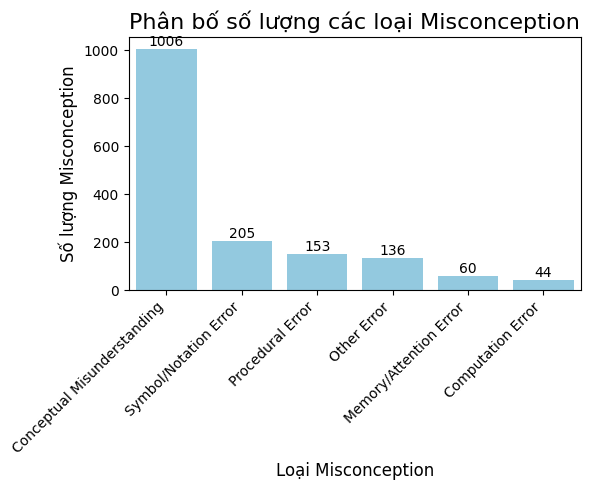

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count unique Misconception values for each misconception_category
category_counts = (
    misconception_df.groupby('MisconceptionType')['Misconception']
    .nunique()
    .reset_index()
    .rename(columns={'Misconception': 'UniqueMisconceptionCount'})
)

# Sort the data by unique question count in descending order
category_counts = category_counts.sort_values(by='UniqueMisconceptionCount', ascending=False)

# Set figure size
plt.figure(figsize=(6, 5))

# Create the bar plot
sns.barplot(
    data=category_counts,
    x='MisconceptionType',
    y='UniqueMisconceptionCount',
    color='skyblue'  # Single consistent color

)

# Customize the plot
plt.title('Phân bố số lượng các loại Misconception', fontsize=16)
plt.xlabel('Loại Misconception', fontsize=12)
plt.ylabel('Số lượng Misconception', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for i, row in enumerate(category_counts.itertuples()):
    plt.text(i, row.UniqueMisconceptionCount, str(row.UniqueMisconceptionCount), ha='center', va='bottom', fontsize=10)

# Add grid lines
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


*Nhận xét:*
- `Conceptual Misunderstanding` là loại lỗi phổ biến nhấn với hơn 1000 `Misconception`.
- Các loại lỗi khác có số lượng `Misconception` thấp hơn, chỉ khoảng 200 - 40 `Misonception`

=>  Điều này có thể cho thấy rằng đa số lỗi người học gặp phải là do lỗi hiểu, mức hiểu bài trong quá trình học tập, thay vì các lỗi liên quan đến quá trình làm bài, tính toán

**Phân phối của `SubjectMainCategory` theo tỉ lệ phần trăm lỗi (`MisconceptionType`) là gì?** 

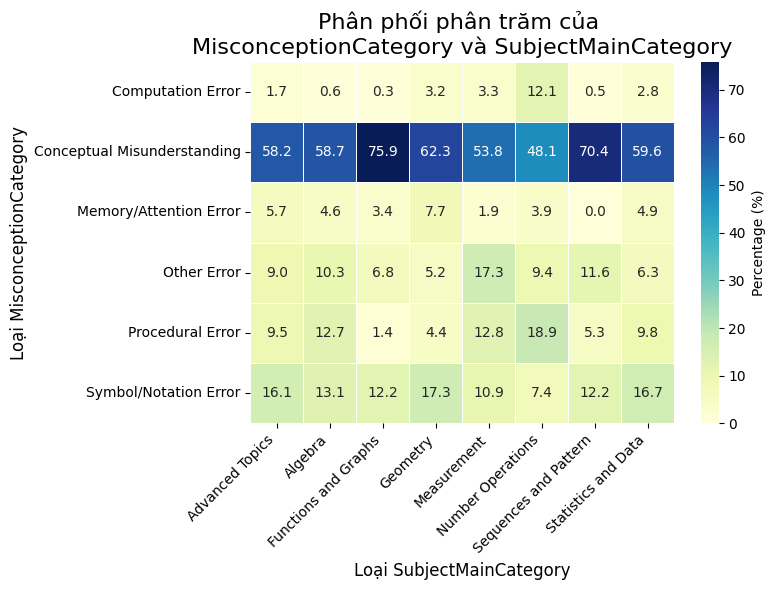

In [27]:
# Create a crosstab between misconception_category and SubjectMainCategory
heatmap_data = pd.crosstab(
    misconception_df['MisconceptionType'],
    misconception_df['SubjectMainCategory']
)

# Normalize the crosstab to percentages by column
heatmap_data_percentage = heatmap_data.div(heatmap_data.sum(axis=0), axis=1) * 100

# Set figure size
plt.figure(figsize=(8, 6))

# Plot the heatmap
sns.heatmap(
    heatmap_data_percentage,
    annot=True,  # Annotate cells with the numeric value
    fmt='.1f',   # Display values as percentages with one decimal point
    cmap='YlGnBu',  # Color map
    linewidths=0.5,  # Add gridlines
    cbar_kws={'label': 'Percentage (%)'}  # Color bar label
)

# Customize the plot
plt.title('Phân phối phân trăm của \nMisconceptionCategory và SubjectMainCategory', fontsize=16)
plt.xlabel('Loại SubjectMainCategory', fontsize=12)
plt.ylabel('Loại MisconceptionCategory', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


*Nhận xét:*
- `Conceptual Misunderstanding` là loại lỗi được mắc phải nhiều nhất (từ 48.1% - 75.9%) đối với tất cả các chủ đề toán. Điều này đóng góp vào giả thuyết trên của chúng ta, rằng đa số lỗi của người học mắc phải liên quan đến mức hiểu đối với nội dung câu hỏi.
- `Computation Error` là loại lỗi ít bị mắc nhất của hầu như các chủ đề toán học, trừ `Number Operation` (12.1%). Tương tự, `Memmory/Attention Error` cũng là một lỗi bị mắc khá ít (nhiều nhất chỉ 7.7% - thuộc về chủ đề `Geometry`), và thậm chí không xuất hiện trong chủ đề `Sequence and Pattern`
- `Procedure Error` thường bị mắc bời các chủ đề `Number Operation`, `Mesurement`, `Algebra`, `Statistics and Data` (>=9.5%), và ít xuất hiện trong chủ đề `Functions and Graphs`, `Geometry` và `Sequence and Pattern`.
- `Symbol/Notation Error` thường bị mắc phải ở tất cả các chủ đề, và thấp nhất ở `Number Operations` (7.4%).

**Phân phối của `ConstructActionType` theo tỉ lệ phần trăm lỗi (`MisconceptionType`) là gì?** 

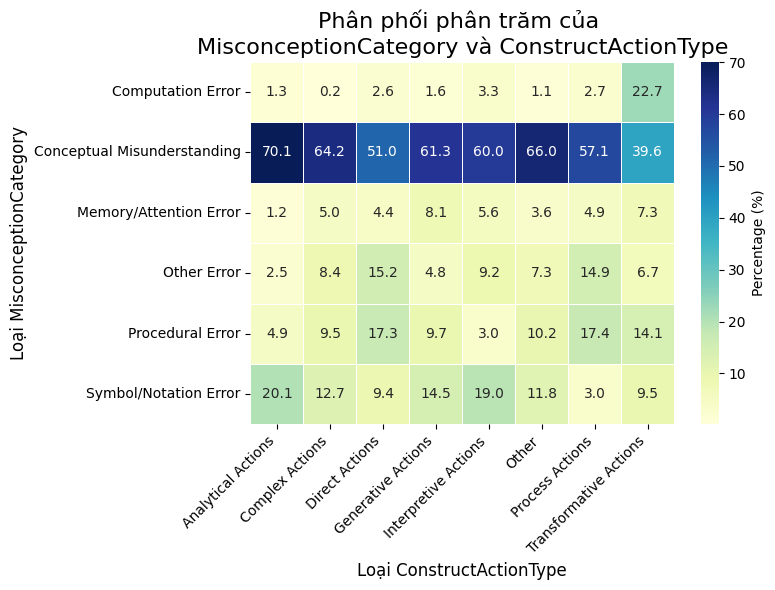

In [28]:
# Create a crosstab between misconception_category and SubjectMainCategory
heatmap_data = pd.crosstab(
    misconception_df['MisconceptionType'],
    misconception_df['ConstructActionType']
)

# Normalize the crosstab to percentages by column
heatmap_data_percentage = heatmap_data.div(heatmap_data.sum(axis=0), axis=1) * 100

# Set figure size
plt.figure(figsize=(8, 6))

# Plot the heatmap
sns.heatmap(
    heatmap_data_percentage,
    annot=True,  # Annotate cells with the numeric value
    fmt='.1f',   # Display values as percentages with one decimal point
    cmap='YlGnBu',  # Color map
    linewidths=0.5,  # Add gridlines
    cbar_kws={'label': 'Percentage (%)'}  # Color bar label
)

# Customize the plot
plt.title('Phân phối phân trăm của \nMisconceptionCategory và ConstructActionType', fontsize=16)
plt.xlabel('Loại ConstructActionType', fontsize=12)
plt.ylabel('Loại MisconceptionCategory', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


*Nhận xét:*
- Giống như với biểu đồ trên, `Conceptual Misunderstanding` cũng là lỗi bị mắc phải nhiều nhất đối với tất cả các loại dạng bài (`Action`) (từ 39.6 - 70.1%)
- `Computation Error` và `Memory/Attention Error` lại là những lỗi **hầu như** ít bị mắc phải nhất, ngoại trừ trường hợp của `Computation Error` và `Transformation Actions`. Điều này có thể cho thấy rằng các dạng bài toán yêu cầu biến đổi thường yêu cầu tính toán phức tạp/dài, dẫn đến sai sót trong tính toán nhiều.
- Nhìn chung, người học thường sai một số loại lỗi (ngoại trừ `Conceptual Misunderstanding`) nhất định. Đối với các dạng bài yêu cầu phân tích, thấu hiểu, phức tạp hơn thì thường sai lỗi về `Symbol/Notation Error` hơn (`Analytical Actions`, `Complex Actions`, `Generative Actions`, `Interpretive Actions` - với tỉ lệ >12%), còn đối với dạng bài với yêu cầu cụ thể, dễ hiểu hơn thì thường sai lỗi `Procedure Error` (`Direct Action`, `Process Actions`)

### 3.3 Insights

- Từ phân tích tỉ lệ và phân phối đối với chủ đề toán học và dạng bài, có thể đưa ra giả thuyết là người học thường mắc lỗi nhiều nhất là do mức hiểu (`Conceptual Misunderstanding`). Điều này có thể do chưa nắm rõ nội dung trong quá trình học, hoặc chưa biết nội dung học (được kiểm tra).
- Các lỗi về trí nhớ, độ tập trung (`Memory/Attention Error`) và tính toán (`Computation Error`) là các lỗi ít bị mắc phải nhất (trừ trường hợp của dạng bài biến đổi (`Transformative Actions`) và chủ đề tính toán số (`Number Operation` đối với lỗi `Computation Error`)
- Hầu như các chủ đề toán đều có nhiều lỗi về `Symbol/Notation Error`.
- Nhìn chung, đối với các dạng bài yêu cầu phần tích, thấy hiểu, người học thường sai lỗi `Sumbol/Notation Error` nhiều hơn; đối với dạng bài có yêu cẩu cụ thể thì thường sai lỗi `Procedure Error` nhiều hơn)


## 4. Insights summaries

- Các chủ đề trong bộ dữ liệu huấn luyện tập trung vào các nội dung toán học từ bậc tiểu học (`Number Operation`, `Measurement`) đến trung học cơ sở (các chủ đề khác).
- Chủ đề phổ biến nhất là `Number Operation` (Thao tác số học) và `Algebra` (Đại số).
- Các chủ đề toán học có nhiều câu hỏi (`QuestionId`) xuất hiện trong dữ liệu thường cũng có nhiều loại lỗi (`Misconception`) bị mắc phải.
- Đa số các lỗi (`Misconception`) chỉ thuộc về một chủ đề duy nhất. Trong đó, phần lớn các lỗi này chỉ liên quan đến một chủ đề phụ duy nhất, cho thấy rằng các lỗi thường rất cụ thể đối với một bối cảnh hoặc nội dung cụ thể.
- Đối với các lỗi liên quan đến hai chủ đề, đa số các cặp giao thoa giữa các chủ đề thường là các chủ đề phổ biến như `Number Operation` và `Algebra`.
- `Direct Actions` là dạng bài phổ biến nhất, được sử dụng trong tất cả các chủ đề toán học. Điều này cho thấy nhiều câu hỏi tập trung vào việc kiểm tra các ý tưởng cơ bản của toán học.
- Một số loại dạng bài (`Action`) tập trung vào một chủ đề cụ thể (`Complex Actions` trong `Algebra`), một số khác xuất hiện ở nhiều chủ đề (`Direct Actions`), và có loại không tập trung vào bất kỳ chủ đề nào (`Generative Actions`).
- Mặc dù `Number Operation` và `Algebra` là hai chủ đề lớn, phân bố dạng bài của chúng khác nhau:
  - `Number Operation` sử dụng tất cả các dạng bài đã phân tích.
  - `Algebra` tập trung chủ yếu vào các dạng bài `Complex Actions` và `Direct Actions`.
- Phân tích tỉ lệ và phân phối theo chủ đề và dạng bài cho thấy người học thường mắc lỗi nhiều nhất là do hiểu sai nội dung (`Conceptual Misunderstanding`). Điều này có thể xuất phát từ việc chưa nắm rõ hoặc chưa học kỹ nội dung được kiểm tra.
- Các lỗi về trí nhớ và độ tập trung (`Memory/Attention Error`) và tính toán (`Computation Error`) là các lỗi ít bị mắc phải nhất, ngoại trừ dạng bài biến đổi (`Transformative Actions`) và chủ đề tính toán số (`Number Operation`) liên quan đến lỗi `Computation Error`.
- Hầu hết các chủ đề toán học đều có nhiều lỗi liên quan đến ký hiệu và ký pháp (`Symbol/Notation Error`).
- Nhìn chung:
  - Đối với các dạng bài yêu cầu phân tích và hiểu sâu, người học thường mắc lỗi `Symbol/Notation Error`.
  - Đối với các dạng bài có yêu cầu cụ thể hơn, lỗi phổ biến hơn là `Procedure Error`.
